## Setup

In [2]:
# common imports
import numpy as np
import os

# random seed consistent
np.random.seed(420)

# to plot pretty pictures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models_mine"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()  # I don't know what this does.
    plt.savefig(path, format='png', dpi=300)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Linear regression using Normal Equation

In [7]:
X = 10 * np.random.rand(100,1)
y = 6 + -1 * X + np.random.rand(100,1)

Saving figure generated_data_plot


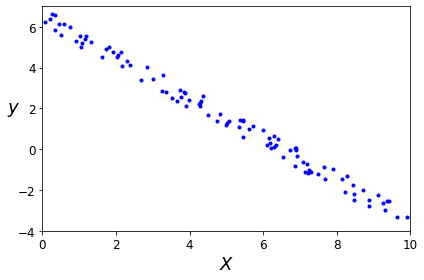

In [21]:
plt.plot(X, y, 'b.')
plt.xlabel('$X$', fontsize=18)
plt.ylabel('$y$', fontsize=18, rotation=0)
plt.axis([0,10,-4,7])
save_fig("generated_data_plot")
plt.show()

In [25]:
X_b = np.c_[np.ones((100,1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best # we're expecting [[6],[-1]]

array([[ 6.48478403],
       [-0.99609008]])

We can make predictions using this.

In [27]:
X_new = np.array([[0],[10]]) # predictions at points 0 and 10
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 6.48478403],
       [-3.47611672]])

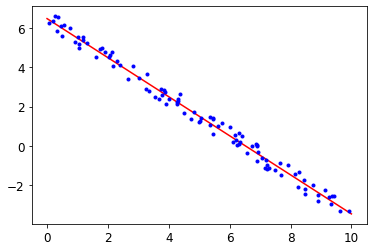

In [28]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.show()

### Equivalent code in Scikit-Learn

In [31]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_
lin_reg.predict(X_new)

array([[ 6.48478403],
       [-3.47611672]])

## Complexity

We have $\theta = (X^T X)^{-1} X^T y$, which has $O(m^3 + m^2n)$ complexity, where $m$ is the number of features, while $n$ is the number of data points. This is apparently bad due to the $m^3$, but gradient decent has $O(m^2n)$, which is much better.

## Gradient decentm

The main idea is: $$\theta_{i+1} = \theta_i - \eta \nabla_\theta \textrm{MSE} (\theta_i),$$ where $\eta$ is the learning rate.

In [65]:
eta = 0.02
n_iterations = 1000
n = 100 # number of data points

theta = np.random.randn(2,1) # random normally distributed vector

for iteration in range(n_iterations):
    gradient = 2/n * X_b.T.dot(X_b.dot(theta)-y)
    theta = theta - eta * gradient

theta

array([[ 6.48436474],
       [-0.99602479]])

When we run this with $\eta = 0.1$ we didn't get such a good result.

In [83]:
def plot_gradient_descent(theta, eta, theta_path=None, limit_axis=True):
    # theta_path is a list where we store the thetas generated
    n = len(X_b) # number of data points
    plt.plot(X, y, "b.")
    plt.xlabel("$x_1$")
    if limit_axis:
        plt.axis([0,10,-4,7])
    plt.title("$\eta = {}$".format(eta))
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 500 and iteration % 40 == 0: # we only want to show a few lines
            y_predict = X_new_b.dot(theta)
            style = 'b-' if iteration > 0 else 'r-'
            plt.plot(X_new, y_predict, style)
        gradient = 2/n * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradient
        if theta_path is not None:
            theta_path.append(theta)

<ipython-input-83-b136ead96c59>:16: RuntimeWarning: invalid value encountered in subtract
  theta = theta - eta * gradient


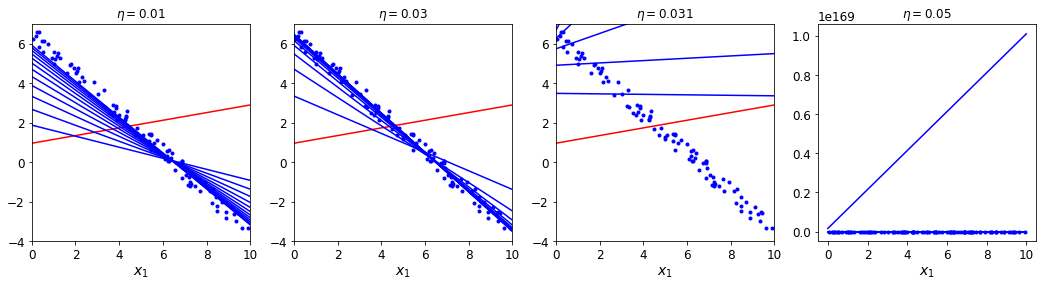

Saving figure batch_gradient_descent_visualisation


<Figure size 432x288 with 0 Axes>

In [94]:
theta = np.random.rand(2,1) # random initialization of theta

plt.figure(figsize=(18,4))
plt.subplot(141); plot_gradient_descent(theta, eta=0.01)
plt.subplot(142); plot_gradient_descent(theta, eta=0.03)
plt.subplot(143); plot_gradient_descent(theta, eta=0.031)
plt.subplot(144); plot_gradient_descent(theta, eta=0.05, limit_axis=False)
plt.show()
save_fig("batch_gradient_descent_visualisation")

## Stochastic gradient descent

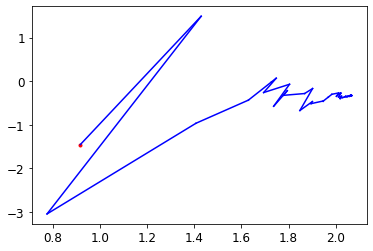

array([[ 2.06655496],
       [-0.32740686]])

In [117]:
n_epochs = 10
t0, t1 = 5, 500 # learning hyperparameters

def learning_schedule(t, t0, t1):
    return np.exp(-0.1*t) * 0.03

theta = np.random.randn(2,1) # random initialisation

plt.plot(theta[0], theta[1],"r.")

for epoch in range(n_epochs):
    for i in range(n):
        random_index = np.random.randint(n)
        xi = X_b[random_index:random_index+1] # why not just random_index?
        yi = y[random_index:random_index+1]
        gradient = 2 * xi.T.dot(xi.dot(theta) - yi)
        t = epoch * n + i
        eta = learning_schedule(t, t0, t1)
        theta_prev = theta
        theta = theta - eta * gradient
        segment = np.c_[theta_prev, theta]
        plt.plot(segment[0], segment[1], "b-")
plt.show()
theta

Let us do that with the SGDRegressor from Scikit-Learn

In [120]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())   # what does the .ravel() do?
sgd_reg.intercept_, sgd_reg.coef_

(array([6.48474041]), array([-1.05528288]))

# Polynomial Regression

First we generate some data to fit the model to.

In [128]:
n = 100
X = 3 * (np.random.randn(n,1) - 1)
y = 3 * X**2 + X + 2 + 5*np.random.randn(n,1)

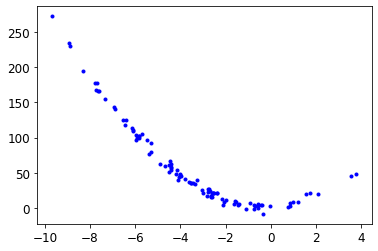

In [129]:
plt.plot(X, y, "b.")

In [130]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[0])
print(X_poly[0])

[-8.30427625]
[-8.30427625 68.96100406]


In [131]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.41090185]), array([[1.23131983, 3.03724639]]))

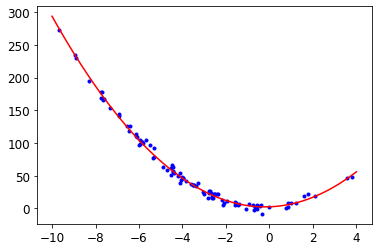

In [137]:
X_new = np.linspace(-10,4,100).reshape(100,-1)
X_new_poly = poly_features.fit_transform(X_new)

y_predict = lin_reg.predict(X_new_poly)

plt.plot(X, y, "b.")
plt.plot(X_new, y_predict, "r-")
plt.show()

# Learning Curves